In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import oxyba as ox
from importlib import reload; reload(ox);

In this article we apply `block_idxmat_shuffle` for k-fold Cross-Validation

### Load a demo dataset

In [2]:
from sklearn.datasets import load_boston
tmp = load_boston()
N = len(tmp.target);
y = tmp.target
X = np.c_[ np.ones(shape=(N,1)), tmp.data[:,[5,12]] ];
#X = np.c_[ tmp.data[:,[5,12]] ];

### Generate Blocks
We are using ten blocks

In [3]:
K = 10
#K = 20

However we will generate `K+1` blocks. 
The additional block is the test block that will be used for the ultimate model test.
Assign the `N` row indicies randomly to the `K+1` blocks

In [4]:
np.random.seed(42)
idx, _ = ox.block_idxmat_shuffle(N,K+1)

### Remove the Test Block for later usage
The `idx` matrix contains `K+1` columns wheras the one column is the test block (I discretionary pick the last one). 
Store the row indicies in a seperate variable `idx_test` and delete this column from `idx`

In [5]:
idx_test = idx[:,-1]
idx = idx[:,:K]

### Fit the model K-times
Let's loop over all `K` blocks and run a linear regression for each.

In [6]:
errors = []
coeffs = []

for b in range(K):
    #temporary store indicies when using block b for validation
    idx_valid = idx[:,b]
    idx_train = idx[:,[c for c in range(K) if c is not b]]
    idx_train = idx_train.reshape((np.prod(idx_train.shape),))
    
    #estimate with all blocks that are not block b
    beta = ox.linreg_ols_lu( y[idx_train], X[idx_train,:] )
    
    #compute error of validation block
    ssr = ox.linreg_ssr( y[idx_valid], X[idx_valid,:], beta )
    
    #store the results
    errors.append(ssr)
    coeffs.append(beta)

### Eyeball the CV error
The SSR errors for `K` model estimations

In [7]:
errors

[1210.1204486366632,
 1644.4395574125672,
 1255.066991306598,
 751.4737008987915,
 894.3232425943116,
 1252.9153409807957,
 2177.6917011295136,
 1307.0535571216994,
 2413.241211782481,
 1539.9019647982748]

The **CV error** is the average of all predictions errors on the validation sets $CV = 1/K \sum_{b=1}^K error_b$

In [8]:
CVerror = np.mean(errors)
CVerror.round(1)

1444.6

and the $CV_\sigma$ is

In [9]:
CVstd = np.std(errors)
CVstd.round(1)

495.4

### Eyeball the estimated coefficients
The second `X` variable fluctates around `-0.6**` and seems to be stable.
However, the intercept and first `X` variable fluctate a lot.

In [10]:
coeffs

[array([-1.09158302,  5.08211545, -0.64482444]),
 array([ 1.2630857 ,  4.70182935, -0.65549503]),
 array([-1.99476753,  5.2643    , -0.65887735]),
 array([-1.7791738 ,  5.19193636, -0.63935956]),
 array([-1.66717213,  5.17161521, -0.6404554 ]),
 array([-3.25019204,  5.41816829, -0.63567991]),
 array([-6.75956921,  5.86500093, -0.59705978]),
 array([ 0.19023594,  4.86762755, -0.64849271]),
 array([-5.45458379,  5.61631636, -0.57820467]),
 array([-0.00527083,  4.90919767, -0.65244998])]

It seems that the intercept is sensitive to subsamples of the first `X` variable. 

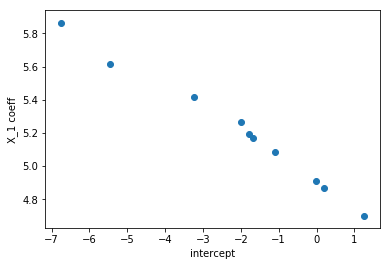

In [11]:
tmp = np.array(coeffs)
plt.scatter(x=tmp[:,0], y=tmp[:,1])
plt.xlabel('intercept');
plt.ylabel('X_1 coeff');

The CV error is approx 1400 and we could check if the intercept and first `X` variable behave somewhat stable for subsamples with SSR errors close to the mean CV error. 
However it is not the case (see column `0` for SSR errors around 1400, look right at column `1` for the intercept parameter, and column `2` for the first `X` parameter)

In [12]:
import pandas as pd
pd.DataFrame( np.c_[np.array(errors), np.array(coeffs)] ).sort_values(by=[0], axis=0)

,0,1,2,3
3,751.473701,-1.779174,5.191936,-0.639360
4,894.323243,-1.667172,5.171615,-0.640455
0,1210.120449,-1.091583,5.082115,-0.644824
5,1252.915341,-3.250192,5.418168,-0.635680
2,1255.066991,-1.994768,5.264300,-0.658877
7,1307.053557,0.190236,4.867628,-0.648493
9,1539.901965,-0.005271,4.909198,-0.652450
1,1644.439557,1.263086,4.701829,-0.655495
6,2177.691701,-6.759569,5.865001,-0.597060
8,2413.241212,-5.454584,5.616316,-0.578205


What to try next? (Iterate!)

* increase the number of blocks `K`
* remove the intercept from the model as it overcompensate fluctuations in the first X variables

### What to do next?
* compare the CV error $CV$ of different models, algorithms, hyperparameters, etc. (model selection)
* compare the test set (test block) with the $CV$ and $CV_\sigma$